**Solving the Word in Context Task using contestual embeddings**

In [1]:
!pip install umap
!pip install transformers

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3541 sha256=1d8300e3d42cedd974fa22f602463997955c9ed9f8462fc10f370145fbed9e3b
  Stored in directory: /root/.cache/pip/wheels/82/d8/73/e9eb3334baaad795ff0278363ff1aca7568bdf2793e452a527
Successfully built umap


In [2]:
import os
import numpy as np
import pandas as pd

import torch
# The Fast version is written in Rust
# it's highly parallel, but in this case, what matters most
# is that it returns a BatchEncoding object, with additional
# methods such as keeping association between original words
# and the tokens they generated
from transformers import DistilBertModel, DistilBertTokenizerFast

#import umap
from umap import umap_
import matplotlib.pyplot as plt
from scipy.spatial import distance


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

We start by loading some sentences featuring the word bank in different contexts.
Our goal is to show the main strenght of transformer models: the embedding learnt depend on the context.
Instead of having just one embedding that summarizes all the senses of bank in the contexts offered by the corpus, we have one for each sentence.
This should allow us to capture different meaning nuances and justifies the usage of these embeddings to establish whether the same sense of a word is employed in two different contexts.

Note: the file to use should be named Sentences.txt, and be located in a sentences folder.

In [3]:
data = {
    'meanings': [],
    'sentences': [],
    'indexes': [],
    'colors': []
}

curr_sentences = []
indexes = []
file_name = 'Sentences.txt'
file_path = os.path.join('sentences', file_name)
with open(file_path, 'r') as file:
  for sentence in file:
    if sentence[0] != '\n':
      if sentence[0] == '[':
        curr_meaning = sentence[1:len(sentence)-3]
        data['meanings'].append(curr_meaning)
        if (len(curr_sentences) > 0):
          data['sentences'].append(curr_sentences)
          data['indexes'].append(indexes)
        curr_sentences = []
        indexes = []
      else:
        print(sentence[0:-1].split('\t'))
        sent, word_index = sentence[0:-1].split('\t')
        curr_sentences.append(sent)
        indexes.append((int)(word_index))

data['sentences'].append(curr_sentences)
data['indexes'].append(indexes)
data['colors'] = ['b', 'g', 'r', 'c', 'm']
df = pd.DataFrame(data)

['She deposited her paycheck at the local bank.', '7']
['The bank approved his loan for a new house.', '1']
['He waited in line to withdraw cash from the bank.', '9']
['The bank offers better interest rates this year.', '1']
['Their savings were securely stored in the bank.', '7']
['The bank closed early due to the holiday.', '1']
['She works in a multinational investment bank.', '6']
['He visited the bank to open a checking account.', '3']
['The bank manager explained the mortgage process.', '1']
['The company secured funding through a bank loan.', '6']
['They had a picnic on the grassy bank of the river.', '7']
['A willow tree stood tall near the river bank.', '8']
['Fishermen sat patiently along the muddy bank.', '6']
['Ducks waddled down to the bank for a swim.', '5']
['The floodwaters rose and overflowed the bank.', '6']
['Children skipped stones from the river bank.', '6']
['The bank eroded after weeks of heavy rain.', '1']
['They built a small dock along the river bank.', '9']
[

In [ ]:
df

,meanings,sentences,indexes,colors
0,Financial Institution,[She deposited her paycheck at the local bank....,"[7, 1, 9, 1, 7, 1, 6, 3, 1, 6]",b
1,River Bank,[They had a picnic on the grassy bank of the r...,"[7, 8, 6, 5, 6, 6, 1, 9, 4, 6]",g
2,Storage / Reserve,"[He donated blood at the local blood bank., Th...","[7, 2, 6, 8, 2, 2, 3, 6, 5, 5]",r
3,Row or Tier,[The pilot pressed a switch on the upper bank....,"[8, 1, 5, 5, 1, 6, 1, 3, 6, 1]",c
4,Specialized Uses / Other,"[A fog bank rolled in from the sea., She lost ...","[2, 8, 5, 1, 6, 2, 1, 6, 6]",m


The meanings column contains the indended meaning of bank in the provided contexts, which are stored in a list in the sentences column.
Indexes contains the position of the word bank in the context.
colors associates a color to each meaning for visualization purposes.

In [4]:
# caricamento del modello pre-allenato
model = DistilBertModel.from_pretrained('distilbert-base-uncased')
# caricamento del tokenizzatore in modo da preparare
# i dati di input nel formato adatto al modello
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

We now implement the computation of the contextual embedding of a word for a given sentence

In [5]:
def compute_embeddings(sentence, word_index):
  # sfruttiamo le funzioni messe a disposizione
  # da HugginFace per il modello distilbert

  # input tokenization using custom BERT's algorithm (not byte-pair)
  # padding and truncation make sure that each sentence of the batch has
  # the same lenght, if necessary by discarding some tokens
  # doesn't matter in our case, since we have batches of single sentences
  # returs a pytorch tensor
  inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)

  # maps token to the words they come from (es. in bakes, bake and s have the same word id)
  word_ids = inputs.word_ids()
  # computes ids of tokens of words to be embedded
  token_indexes = [i for i in range(len(word_ids)) if word_ids[i] == word_index]

  # embedding computation
  with torch.no_grad():
    output = model(**inputs)


  # recovers all the embeddings of tokens associated  to the target word
  term_embeddings = output.last_hidden_state[0, token_indexes[0]:(token_indexes[-1]+1), :]

  # word embedding is the average of embeddings of constituents tokens
  return term_embeddings.mean(dim = 0).numpy()

In [6]:
points_colors = []
embeddings = []
means = []
embeddings_list = []
for index, row in df.iterrows():
  # coputes all the embeddings of bank for a group of sentences
  group_embeddings = []
  for i in range(len(row['sentences'])):
    embedding = compute_embeddings(row['sentences'][i], row['indexes'][i])
    group_embeddings.append(embedding)
    embeddings_list.append(embedding)
    points_colors.append(row['colors'])
  embeddings.append(group_embeddings)
  # column with all the embeddings
  matrix = np.vstack(group_embeddings)
  # embedding medio: la componente i è la media
  # delle componenti i-esime degli embeddings del gruppo
  means.append(np.mean(matrix, axis=0))

df['means'] = means
df['embeddings'] = embeddings

In [7]:
df

,meanings,sentences,indexes,colors,means,embeddings
0,Financial Institution,[She deposited her paycheck at the local bank....,"[7, 1, 9, 1, 7, 1, 6, 3, 1, 6]",b,"[0.07426979, -0.16003045, -0.100871965, -0.037...","[[0.1282393, -0.12150147, -0.13719314, 0.08376..."
1,River Bank,[They had a picnic on the grassy bank of the r...,"[7, 8, 6, 5, 6, 6, 1, 9, 4, 6]",g,"[0.055935908, -0.086778924, -0.25631544, 0.214...","[[-0.11449079, -0.12522551, -0.050543718, 0.21..."
2,Storage / Reserve,"[He donated blood at the local blood bank., Th...","[7, 2, 6, 8, 2, 2, 3, 6, 5, 5]",r,"[0.04597649, -0.2258416, 0.0118487375, 0.07492...","[[0.42159942, -0.36582977, 0.1700837, -0.05525..."
3,Row or Tier,[The pilot pressed a switch on the upper bank....,"[8, 1, 5, 5, 1, 6, 1, 3, 6, 1]",c,"[0.03710925, 0.069076836, -0.006316951, 0.1320...","[[-0.13791606, -0.15726735, -0.1521311, 0.4797..."
4,Specialized Uses / Other,"[A fog bank rolled in from the sea., She lost ...","[2, 8, 5, 1, 6, 2, 1, 6, 6]",m,"[0.13833031, -0.008395864, 0.13231494, 0.07572...","[[0.2761735, -0.008584316, 0.28140774, -0.0300..."


**Comparing embeddings of the word Bank in different contexts**

We now reduce the dimensionality of embeddings down to 2, using umap.
The cosine similarity is employed, since it's usually most suitable for word embeddings.

In [8]:
umap_model = umap_.UMAP(n_components=2, min_dist=0.0, metric='cosine', random_state=42)

In [9]:
reduced_embeddings = umap_model.fit_transform(embeddings_list)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
len(reduced_embeddings)

50

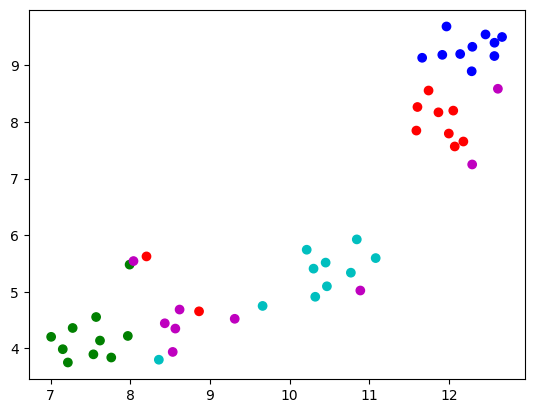

In [10]:
plt.scatter(reduced_embeddings[:,0], reduced_embeddings[:,1],c=points_colors)

We observe that clusters are quite compact and well-apart, meaning that the vector effectively capture the mening differences.
It'also interested to note that bank as financial institution (blue) and bank as reserve (red) are actually quite close, which refeclts they similarity in meaning.
This is a good example of how embeddings (both static and contextual) can actually capture meaning relations.
The same can be said for bank as river bank (green) and bank as row (cyan).

The "others" vectors are quite scattered: it makes perfect sense, given that this group contains eterogeneous usages of the word.

In [11]:
reduced_means = umap_model.fit_transform(means)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


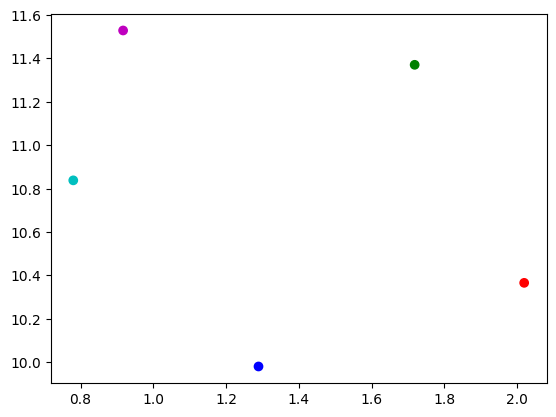

In [12]:
plt.scatter(reduced_means[:,0], reduced_means[:,1],c=df['colors'])

It's interesting to note that means of embeddings of similar meaning (red vs blue and cyan vs green) tend to lie on straight segments.
The means of embeddings of similar meaning tend to be cloaser then those of different meanings, confirming that we can use the mean as a representative of a group of similar contexts.

In [13]:
def cos_sim(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)

    dot_product = np.dot(v1, v2)
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)
    if magnitude_v1 == 0 or magnitude_v2 == 0:
        return 0.0

    return dot_product / (magnitude_v1 * magnitude_v2)

In [14]:
# computing intra-group
for i in range(df.index.size):
  row_outer = df.iloc[i]
  for j in range(i + 1, df.index.size):
    row_inner = df.iloc[j]
    print(f"Cosine similarity between {row_outer['meanings']} and {row_inner['meanings']}: {cos_sim(row_outer['means'], row_inner['means'])}")

Cosine similarity between Financial Institution and River Bank: 0.7460963129997253
Cosine similarity between Financial Institution and Storage / Reserve: 0.8704840540885925
Cosine similarity between Financial Institution and Row or Tier: 0.7652022242546082
Cosine similarity between Financial Institution and Specialized Uses / Other: 0.8238967061042786
Cosine similarity between River Bank and Storage / Reserve: 0.76839679479599
Cosine similarity between River Bank and Row or Tier: 0.7618629932403564
Cosine similarity between River Bank and Specialized Uses / Other: 0.8761814832687378
Cosine similarity between Storage / Reserve and Row or Tier: 0.8304646015167236
Cosine similarity between Storage / Reserve and Specialized Uses / Other: 0.8652175068855286
Cosine similarity between Row or Tier and Specialized Uses / Other: 0.8995945453643799


The cosine similarity values confirm the observations made before.
Note that similarity with the "others" group should really be discarded, given the eterogeneity of this group.

In [15]:
df.iloc[0]

,0
meanings,Financial Institution
sentences,[She deposited her paycheck at the local bank....
indexes,"[7, 1, 9, 1, 7, 1, 6, 3, 1, 6]"
colors,b
means,"[0.07426979, -0.16003045, -0.100871965, -0.037..."
embeddings,"[[0.1282393, -0.12150147, -0.13719314, 0.08376..."


**Solving the WiC task**

We are asked to asses whether two usages of the same word in different context refer to the same sense.
We can employ BERT's contextualized embeddings, given their evident ability to capture the context of the word.
But how do we go from embeddings of the word in the two contexts to the final label value?
An idea is to annotate each pair of sentences with a set of features that measure the difference between embeddings, thus leveraging the fundamental equation of the distributional approach: similarity in embeddings = similarity in meaning.
The following features are used:

1) euclidean distance: classical choice to measure distance between vectors, not really suitable for our case, given that our vectors have high dimensionality, and the measure is really sensible to single components variations

2) manhattan distance: less sensible to single components variations, thus more suitable for high dimensional spaces

3) cosine similarity: only considers the angle between vectors, not the single components. The best choice for high dimensional spaces.

A logistc regression model is later trained, to predict a probability value from a score, computed as a linear combination of features.

Note: the training set must be loaded in a train directory, while the test set must be places in the test directory.

In [22]:
def read_dataset(folder, file_name):
  file_path = os.path.join(folder, file_name)

  features = []
  with open(file_path, 'r') as file:
    for sentence in file:
      splitted_sent = sentence.split('\t')
      indexes = splitted_sent[2].split('-')
      first_embedding = compute_embeddings(splitted_sent[3],(int)(indexes[0]))
      second_embedding = compute_embeddings(splitted_sent[4][0:-1], (int)(indexes[1]))

      cosine = 1 - cos_sim(first_embedding, second_embedding)
      euclidean = distance.euclidean(first_embedding, second_embedding)
      manhattan = distance.cityblock(first_embedding, second_embedding)
      features.append(np.array([cosine, euclidean, manhattan]))

  return features

In [23]:
def read_labels(folder, file_name):
  file_path = os.path.join(folder, file_name)

  target = []
  with open(file_path, 'r') as file:
    for label in file:
      target.append(1 if label[0:-1] == 'T' else 0)

  return target

In [24]:
training_set = read_dataset('train', 'train.data.txt')
training_labels = read_labels('train', 'train.gold.txt')

In [25]:
test_set = read_dataset('test', 'test.data.txt')
test_labels = read_labels('test', 'test.gold.txt')

In [26]:
test_set

[array([  0.37709826,   8.98763084, 196.67675781]),
 array([  0.28925401,   7.5184617 , 165.29919434]),
 array([  0.32358319,   7.03073502, 156.3425293 ]),
 array([  0.39399987,   9.53245354, 208.80471802]),
 array([  0.17696613,   5.91615868, 130.08773804]),
 array([9.78891253e-02, 4.63746738e+00, 1.03662735e+02]),
 array([  0.26548785,   7.36429596, 160.52236938]),
 array([  0.29827142,   7.91321468, 170.94000244]),
 array([  0.39646327,   8.59065628, 193.14031982]),
 array([  0.16214347,   6.29095697, 138.70326233]),
 array([  0.36936349,   8.562047  , 187.33407593]),
 array([  0.16109651,   6.01201105, 133.14125061]),
 array([  0.38575488,   9.11782169, 195.95704651]),
 array([  0.43483359,  10.82963467, 239.03622437]),
 array([7.05661774e-02, 3.45335197e+00, 7.53665009e+01]),
 array([  0.3515746 ,   9.34769535, 207.66522217]),
 array([  0.41252911,   9.06063175, 200.82437134]),
 array([  0.68120718,  13.96810436, 308.1340332 ]),
 array([  0.46519554,   9.92660904, 220.37463379]),


In [27]:
regression_model = LogisticRegression()
regression_model.fit(training_set, training_labels)

LogisticRegression()

In [28]:
predictions = regression_model.predict(test_set)

In [29]:
accuracy_score(test_labels, predictions)

0.6228571428571429

**Conclusion**

The obtained level of accuracy is in line with the state of the art, as reported [here](https://pilehvar.github.io/wic/).
Overall, this highlights the main strength of transformer-based word embeddings models: their ability to learn embeddings that capture the context of a word.